In [ ]:
#######################################
###
###   Example of Semi-supervised Learning
###
#######################################

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Define transformations for the MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define the number of labeled samples
num_labeled = 100

# Generate random indices for labeled and unlabeled data
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

# Create subsets
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

# Create DataLoaders
batch_size = 64

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

# Load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28x1 -> 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 28x28x32 -> 14x14x32
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 14x14x32 -> 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2)                              # 14x14x64 -> 7x7x64
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(-1, 7*7*64)
        out = self.classifier(features)
        return out

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model on labeled data
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.4f}")

# Function to evaluate the model
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100. * correct / total
    return accuracy

# Initial Training on labeled data
num_epochs_initial = 10
for epoch in range(1, num_epochs_initial + 1):
    train(model, labeled_loader, optimizer, criterion, epoch)
    acc = evaluate(model, test_loader)
    print(f"Test Accuracy after Epoch {epoch}: {acc:.2f}%\n")

# Function to generate pseudo-labels
def generate_pseudo_labels(model, loader, threshold=0.95):
    model.eval()
    pseudo_data = []
    pseudo_labels = []
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            outputs = model(data)
            probabilities = nn.functional.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)
            mask = max_probs >= threshold
            selected_data = data[mask]
            selected_labels = predictions[mask]
            pseudo_data.append(selected_data.cpu())
            pseudo_labels.append(selected_labels.cpu())
    if pseudo_data:
        pseudo_data = torch.cat(pseudo_data, dim=0)
        pseudo_labels = torch.cat(pseudo_labels, dim=0)
        return pseudo_data, pseudo_labels
    else:
        return None, None

# Generate pseudo-labels
pseudo_data, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader, threshold=0.95)
if pseudo_data is not None:
    print(f"Generated {len(pseudo_data)} pseudo-labeled samples.")
else:
    print("No pseudo-labeled samples generated with the given threshold.")

class PseudoLabelDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, target = self.data[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)
        # Convert tensor label to integer
        return img, target.item()

# Create the pseudo-labeled dataset
if pseudo_data is not None:
    pseudo_dataset = PseudoLabelDataset(pseudo_data, pseudo_labels, transform=None)
    
    # Combine labeled and pseudo-labeled datasets
    combined_data = torch.utils.data.ConcatDataset([labeled_dataset, pseudo_dataset])
    combined_loader = DataLoader(combined_data, batch_size=batch_size, shuffle=True)
    
    print(f"Combined dataset size: {len(combined_data)}")
else:
    combined_loader = labeled_loader
    print("Using only the original labeled data for training.")

# Reinitialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Retrain the model on the combined dataset
num_epochs_combined = 5
for epoch in range(1, num_epochs_combined + 1):
    train(model, combined_loader, optimizer, criterion, epoch)
    acc = evaluate(model, test_loader)
    print(f"Test Accuracy after Epoch {epoch}: {acc:.2f}%\n")

Epoch 1: Train Loss: 2.3174
Test Accuracy after Epoch 1: 30.71%

Epoch 2: Train Loss: 1.9994
Test Accuracy after Epoch 2: 46.73%

Epoch 3: Train Loss: 1.6253
Test Accuracy after Epoch 3: 48.63%

Epoch 4: Train Loss: 1.2540
Test Accuracy after Epoch 4: 54.84%

Epoch 5: Train Loss: 0.9179
Test Accuracy after Epoch 5: 65.72%

Epoch 6: Train Loss: 0.6695
Test Accuracy after Epoch 6: 66.78%

Epoch 7: Train Loss: 0.5049
Test Accuracy after Epoch 7: 71.64%

Epoch 8: Train Loss: 0.3740
Test Accuracy after Epoch 8: 67.97%

Epoch 9: Train Loss: 0.2402
Test Accuracy after Epoch 9: 69.42%

Epoch 10: Train Loss: 0.1662
Test Accuracy after Epoch 10: 72.08%

Generated 20659 pseudo-labeled samples.
Combined dataset size: 20759
Epoch 1: Train Loss: 0.0556
Test Accuracy after Epoch 1: 69.76%

Epoch 2: Train Loss: 0.0053
Test Accuracy after Epoch 2: 77.22%

Epoch 3: Train Loss: 0.0009
Test Accuracy after Epoch 3: 76.67%

Epoch 4: Train Loss: 0.0017
Test Accuracy after Epoch 4: 75.54%

Epoch 5: Train Loss

In [1]:
###################################
###
###  Propogating 1-nearest neighbour on MNIST data of images 0 and 4
###
##################################

Fetching MNIST data...


Resizing images:   1%|          | 129/13727 [00:00<00:10, 1285.70it/s]

Total samples after filtering: 13727
Resizing images to 12x12 pixels...


Resizing images: 100%|██████████| 13727/13727 [00:11<00:00, 1223.14it/s]


Shape after resizing: (13727, 144)
Training samples: 11727, Testing samples: 2000
Labeled samples: 300, Unlabeled samples: 20
Normalizing data...
Normalization completed.
Propagating labels to unlabeled data using 1-NN...
Label propagation completed.
Combined training samples: 320
Training Logistic Regression classifier on combined data...
Classifier training completed.
Evaluating the model on the test set...
Test Accuracy: 98.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1006
           4       0.99      0.99      0.99       994

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
[[992  14]
 [ 12 982]]


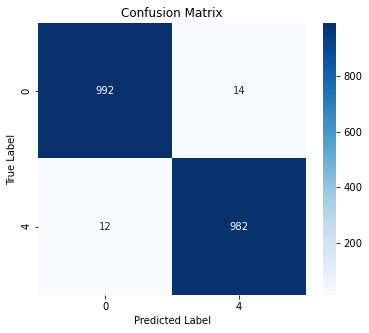

In [7]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
import random
import warnings
from tqdm import tqdm  # For progress bars

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Set Random Seed for Reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# 2. Load and Filter MNIST Dataset
print("Fetching MNIST data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']
y = y.astype(np.int8)

# Filter for digits 0 and 4
filter_digits = [0, 4]
filter_mask = np.isin(y, filter_digits)
X, y = X[filter_mask], y[filter_mask]
print(f"Total samples after filtering: {X.shape[0]}")

# 3. Image Resizing: Scale Images to 8x8 Pixels
def resize_images_vectorized(images, original_size=(28, 28), new_size=(8, 8)):
    num_images = images.shape[0]
    images_reshaped = images.reshape(num_images, original_size[0], original_size[1])
    
    # Initialize an array to hold resized images
    resized_images = np.empty((num_images, new_size[0] * new_size[1]), dtype=np.float32)
    
    # Resize each image and flatten
    for i in tqdm(range(num_images), desc="Resizing images"):
        resized = resize(images_reshaped[i], new_size, anti_aliasing=True)
        resized_images[i] = resized.flatten()
    
    return resized_images

print("Resizing images to 12x12 pixels...")
X_resized = resize_images_vectorized(X, original_size=(28, 28), new_size=(12, 12))
print(f"Shape after resizing: {X_resized.shape}")

# 4. Split Data into Training and Testing Sets
n_test = 2000
X_train, X_test, y_train, y_test = train_test_split(
    X_resized, y, test_size=n_test, stratify=y, random_state=random_seed
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# 5. Further Split Training Data into Labeled and Unlabeled Sets
n_labeled = 300
n_unlabeled = 20

# Ensure that the training set has enough samples
assert n_labeled + n_unlabeled <= X_train.shape[0], "Not enough training samples."

# Initialize lists to hold indices
labeled_indices = []
unlabeled_indices = []

# To ensure class balance, select equal number of labeled samples per class
n_labeled_per_class = n_labeled // len(filter_digits)  # 300 per class

for digit in filter_digits:
    digit_indices = np.where(y_train == digit)[0]
    digit_selected = np.random.choice(digit_indices, n_labeled_per_class, replace=False)
    labeled_indices.extend(digit_selected)
    digit_unselected = list(set(digit_indices) - set(digit_selected))
    unlabeled_indices.extend(digit_unselected)

# Convert lists to numpy arrays
labeled_indices = np.array(labeled_indices)
unlabeled_indices = np.array(unlabeled_indices)

# If we need exactly 4000 unlabeled samples and have more, sample 4000
if len(unlabeled_indices) > n_unlabeled:
    unlabeled_indices = np.random.choice(unlabeled_indices, n_unlabeled, replace=False)
elif len(unlabeled_indices) < n_unlabeled:
    raise ValueError("Not enough unlabeled data available.")
# Else, keep as is

print(f"Labeled samples: {len(labeled_indices)}, Unlabeled samples: {len(unlabeled_indices)}")

# 6. Create Labeled and Unlabeled Datasets
X_labeled = X_train[labeled_indices].astype(np.float32)
y_labeled = y_train[labeled_indices]
X_unlabeled = X_train[unlabeled_indices].astype(np.float32)
# y_unlabeled_true = y_train[unlabeled_indices]  # Not used in training

# 7. Normalize the Data
scaler = StandardScaler()
print("Normalizing data...")
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)
X_test_scaled = scaler.transform(X_test.astype(np.float32))  # Ensure test data is float32
print("Normalization completed.")

# Optional: Function to Plot Samples
def plot_samples(X, y, title, n_samples_per_class=5):
    plt.figure(figsize=(n_samples_per_class, len(filter_digits)))
    for idx, digit in enumerate(filter_digits):
        digit_indices = np.where(y == digit)[0]
        if len(digit_indices) < n_samples_per_class:
            sampled_indices = digit_indices  # Take all if fewer samples
        else:
            sampled_indices = np.random.choice(digit_indices, n_samples_per_class, replace=False)
        for j, sample_idx in enumerate(sampled_indices):
            plt_idx = idx * n_samples_per_class + j + 1
            plt.subplot(len(filter_digits), n_samples_per_class, plt_idx)
            plt.imshow(X[sample_idx].reshape(8,8), cmap='gray')
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot labeled samples (optional)
# plot_samples(X_labeled_scaled, y_labeled, "Labeled Samples")

# 8. Label Propagation Using 1-Nearest Neighbor
print("Propagating labels to unlabeled data using 1-NN...")
knn_propagate = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)  # Utilize all available cores
knn_propagate.fit(X_labeled_scaled, y_labeled)
y_unlabeled_pseudo = knn_propagate.predict(X_unlabeled_scaled)
print("Label propagation completed.")

# 9. Combine Labeled and Pseudo-Labeled Data
X_combined = np.vstack((X_labeled_scaled, X_unlabeled_scaled)).astype(np.float32)
y_combined = np.hstack((y_labeled, y_unlabeled_pseudo)).astype(np.int8)
print(f"Combined training samples: {X_combined.shape[0]}")

# Optional: Plot pseudo-labeled samples (optional)
# plot_samples(X_unlabeled_scaled, y_unlabeled_pseudo, "Pseudo-Labeled Samples")

# 10. Train Classifier on Combined Data
print("Training Logistic Regression classifier on combined data...")
clf = LogisticRegression(
    random_state=random_seed,
    max_iter=1000,
    solver='lbfgs',
    multi_class='auto',
    n_jobs=-1  # Utilize all available cores
)
clf.fit(X_combined, y_combined)
print("Classifier training completed.")

# 11. Evaluate the Model
print("Evaluating the model on the test set...")
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '4']))

print("Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

# 12. Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_mat, classes=['0', '4'])

In [ ]:
###################################
###
###  Propogating logistic regression on MNIST data of images 3 and 7
###
##################################

Fetching MNIST data...
Before loading MNIST - Memory Usage: 1.60 GB


Resizing images:   1%|          | 121/14434 [00:00<00:11, 1204.08it/s]

Total samples after filtering: 14434
After filtering MNIST - Memory Usage: 1.60 GB
Resizing images to 12x12 pixels...


Resizing images: 100%|██████████| 14434/14434 [00:11<00:00, 1281.85it/s]

Shape after resizing: (14434, 144)
After resizing images - Memory Usage: 1.60 GB
Training samples: 12434, Testing samples: 2000
After train-test split - Memory Usage: 1.60 GB
Labeled samples: 400, Unlabeled samples: 1000
After splitting labeled and unlabeled data - Memory Usage: 1.60 GB
Labeled data shape: (400, 144), Unlabeled data shape: (1000, 144)
After creating labeled and unlabeled datasets - Memory Usage: 1.60 GB
Normalizing data...
Before normalization - Memory Usage: 1.60 GB
Normalization completed.
After normalization - Memory Usage: 1.60 GB
After garbage collection - Memory Usage: 1.60 GB
Propagating labels to unlabeled data using Logistic Regression...
Before label propagation - Memory Usage: 1.60 GB


Pseudo-labeled samples: 908 out of 1000
After label propagation - Memory Usage: 1.60 GB
Combining labeled and pseudo-labeled data...
Combined training samples: 1308
After combining datasets - Memory Usage: 1.60 GB
After cleaning up pseudo-labeled data - Memory Usage: 1.60 GB
Training final Logistic Regression classifier on combined data...
Before final classifier training - Memory Usage: 1.60 GB
Final classifier training completed.
After final classifier training - Memory Usage: 1.60 GB
After cleaning up combined data - Memory Usage: 1.60 GB
Evaluating the final model on the test set...
Before evaluation - Memory Usage: 1.60 GB
Test Accuracy: 97.35%

Classification Report:
              precision    recall  f1-score   support

           3       0.98      0.97      0.97       989
           7       0.97      0.98      0.97      1011

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97   

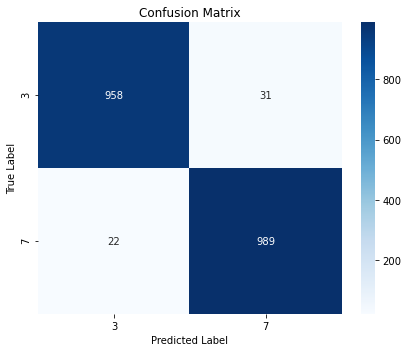

In [15]:
# semi_supervised_mnist_3_7.py

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
import random
import warnings
from tqdm import tqdm  # For progress bars
import gc  # Garbage collector
import psutil  # For memory monitoring

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Set Random Seed for Reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# 2. Function to Monitor Memory Usage
def print_memory_usage(stage=""):
    process = psutil.Process()
    mem = process.memory_info().rss / (1024 ** 3)  # in GB
    print(f"{stage} - Memory Usage: {mem:.2f} GB")

# 3. Load and Filter MNIST Dataset
print("Fetching MNIST data...")
print_memory_usage("Before loading MNIST")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']
y = y.astype(np.int8)

# Filter for digits 3 and 7
filter_digits = [3, 7]
filter_mask = np.isin(y, filter_digits)
X, y = X[filter_mask], y[filter_mask]
print(f"Total samples after filtering: {X.shape[0]}")
print_memory_usage("After filtering MNIST")

# 4. Image Resizing: Scale Images to 12x12 Pixels
def resize_images_vectorized(images, original_size=(28, 28), new_size=(12, 12)):
    num_images = images.shape[0]
    images_reshaped = images.reshape(num_images, original_size[0], original_size[1])
    
    # Initialize an array to hold resized images
    resized_images = np.empty((num_images, new_size[0] * new_size[1]), dtype=np.float32)
    
    # Resize each image and flatten
    print("Resizing images to 12x12 pixels...")
    for i in tqdm(range(num_images), desc="Resizing images"):
        resized = resize(images_reshaped[i], new_size, anti_aliasing=True)
        resized_images[i] = resized.flatten()
    
    return resized_images

X_resized = resize_images_vectorized(X, original_size=(28, 28), new_size=(12, 12))
print(f"Shape after resizing: {X_resized.shape}")
print_memory_usage("After resizing images")

# 5. Split Data into Training and Testing Sets
n_test = 2000
X_train, X_test, y_train, y_test = train_test_split(
    X_resized, y, test_size=n_test, stratify=y, random_state=random_seed
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print_memory_usage("After train-test split")

# 6. Further Split Training Data into Labeled and Unlabeled Sets
n_labeled = 400
n_unlabeled = 1000

# Ensure that the training set has enough samples
assert n_labeled + n_unlabeled <= X_train.shape[0], "Not enough training samples."

# Initialize lists to hold indices
labeled_indices = []
unlabeled_indices = []

# To ensure class balance, select equal number of labeled samples per class
n_labeled_per_class = n_labeled // len(filter_digits)  # 500 per class

for digit in filter_digits:
    digit_indices = np.where(y_train == digit)[0]
    if len(digit_indices) < n_labeled_per_class:
        raise ValueError(f"Not enough samples for digit {digit} to select {n_labeled_per_class} labeled samples.")
    digit_selected = np.random.choice(digit_indices, n_labeled_per_class, replace=False)
    labeled_indices.extend(digit_selected)
    digit_unselected = list(set(digit_indices) - set(digit_selected))
    unlabeled_indices.extend(digit_unselected)

# Convert lists to numpy arrays
labeled_indices = np.array(labeled_indices)
unlabeled_indices = np.array(unlabeled_indices)

# If we need exactly 4000 unlabeled samples and have more, sample 4000
if len(unlabeled_indices) > n_unlabeled:
    unlabeled_indices = np.random.choice(unlabeled_indices, n_unlabeled, replace=False)
elif len(unlabeled_indices) < n_unlabeled:
    raise ValueError("Not enough unlabeled data available.")

print(f"Labeled samples: {len(labeled_indices)}, Unlabeled samples: {len(unlabeled_indices)}")
print_memory_usage("After splitting labeled and unlabeled data")

# 7. Create Labeled and Unlabeled Datasets
X_labeled = X_train[labeled_indices].astype(np.float32)
y_labeled = y_train[labeled_indices]
X_unlabeled = X_train[unlabeled_indices].astype(np.float32)
# y_unlabeled_true = y_train[unlabeled_indices]  # Not used in training

print(f"Labeled data shape: {X_labeled.shape}, Unlabeled data shape: {X_unlabeled.shape}")
print_memory_usage("After creating labeled and unlabeled datasets")

# 8. Normalize the Data
scaler = StandardScaler()
print("Normalizing data...")
print_memory_usage("Before normalization")

X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)
X_test_scaled = scaler.transform(X_test.astype(np.float32))  # Ensure test data is float32

print("Normalization completed.")
print_memory_usage("After normalization")

# 9. Clean Up Unused Data to Free Memory
del X, y, X_resized, X_train, X_unlabeled, y_train  # y_labeled retained for propagation
gc.collect()

print_memory_usage("After garbage collection")

# 10. Label Propagation Using Logistic Regression
print("Propagating labels to unlabeled data using Logistic Regression...")
print_memory_usage("Before label propagation")

# Initialize Logistic Regression model for label propagation
lr_propagate = LogisticRegression(
    random_state=random_seed,
    max_iter=1000,
    solver='lbfgs',
    multi_class='auto',
    n_jobs=-1  # Utilize all available cores
)

# Fit the classifier on labeled data
lr_propagate.fit(X_labeled_scaled, y_labeled)

# Predict probabilities for unlabeled data
probs_unlabeled = lr_propagate.predict_proba(X_unlabeled_scaled)

# Define confidence threshold
confidence_threshold = 0.95

# Assign pseudo-labels where confidence exceeds the threshold
pseudo_labels = lr_propagate.predict(X_unlabeled_scaled)
max_probs = np.max(probs_unlabeled, axis=1)
confident_mask = max_probs >= confidence_threshold

# Extract confident pseudo-labels
X_pseudo = X_unlabeled_scaled[confident_mask]
y_pseudo = pseudo_labels[confident_mask]

print(f"Pseudo-labeled samples: {X_pseudo.shape[0]} out of {X_unlabeled_scaled.shape[0]}")
print_memory_usage("After label propagation")

# 11. Combine Labeled and Pseudo-Labeled Data
print("Combining labeled and pseudo-labeled data...")
X_combined_final = np.vstack((X_labeled_scaled, X_pseudo)).astype(np.float32)
y_combined_final = np.hstack((y_labeled, y_pseudo)).astype(np.int8)
print(f"Combined training samples: {X_combined_final.shape[0]}")
print_memory_usage("After combining datasets")

# Remove individual datasets to free memory
del X_labeled_scaled, X_pseudo, y_pseudo, lr_propagate, probs_unlabeled
gc.collect()

print_memory_usage("After cleaning up pseudo-labeled data")

# 12. Train a Classifier on the Combined Dataset
print("Training final Logistic Regression classifier on combined data...")
print_memory_usage("Before final classifier training")

# Initialize Logistic Regression classifier for final training
clf_final = LogisticRegression(
    random_state=random_seed,
    max_iter=1000,
    solver='lbfgs',
    multi_class='auto',
    n_jobs=-1  # Utilize all available cores
)

# Train the classifier on combined data
clf_final.fit(X_combined_final, y_combined_final)

print("Final classifier training completed.")
print_memory_usage("After final classifier training")

# Remove combined data to free memory
del X_combined_final, y_combined_final
gc.collect()

print_memory_usage("After cleaning up combined data")

# 13. Evaluate the Model on the Test Set
print("Evaluating the final model on the test set...")
print_memory_usage("Before evaluation")

y_test_pred = clf_final.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=[str(digit) for digit in filter_digits]))

# Confusion Matrix
print("Confusion Matrix:")
conf_mat_final = confusion_matrix(y_test, y_test_pred)
print(conf_mat_final)

print_memory_usage("After evaluation")

# 14. Visualize the Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_mat_final, classes=[str(digit) for digit in filter_digits])

In [ ]:
###################################
###
###  Semi-supervised EM algorithm on two-component Gaussian Mixture Model, performance evaluated on estimation accuracy of cluster centers
###
##################################

Estimated Means using only labeled data:
Component 0: [-1.9963988  -1.96493709]
Component 1: [2.06277109 2.07890139]
Accuracy (Total Distance): 0.1361

Converged at iteration 5
Estimated Means using semi-supervised EM:
Component 0: [-2.02456719 -2.01997431]
Component 1: [2.00635102 2.01235128]
Accuracy (Total Distance): 0.0456

Comparison of Accuracies:
Using Only Labeled Data: Total Distance = 0.1361
Using Semi-Supervised EM: Total Distance = 0.0456


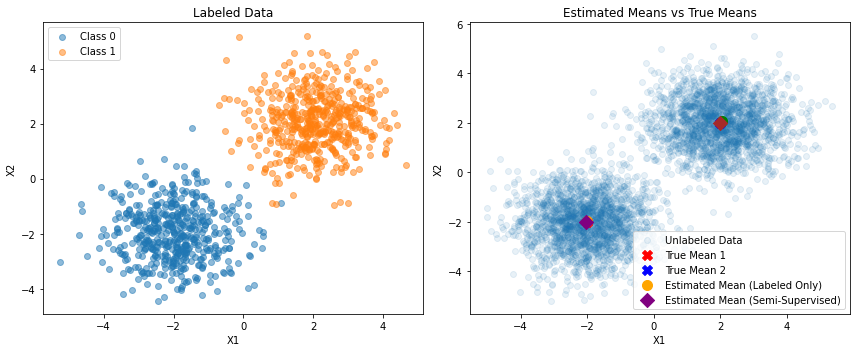

In [36]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

def generate_data(n_labeled=1000, n_unlabeled=4000):
    """
    Generate data from a 2-component Gaussian mixture model.

    Parameters:
        n_labeled (int): Number of labeled data points.
        n_unlabeled (int): Number of unlabeled data points.

    Returns:
        X_labeled (np.ndarray): Labeled data points.
        y_labeled (np.ndarray): Labels for labeled data.
        X_unlabeled (np.ndarray): Unlabeled data points.
    """
    # Define parameters for two Gaussian components
    mean1 = np.array([-2, -2])
    mean2 = np.array([2, 2])
    cov = np.array([[1, 0], [0, 1]])  # Identity covariance

    # Generate labeled data: 500 from each component
    X_labeled_1 = np.random.multivariate_normal(mean1, cov, n_labeled // 2)
    X_labeled_2 = np.random.multivariate_normal(mean2, cov, n_labeled // 2)
    X_labeled = np.vstack((X_labeled_1, X_labeled_2))
    y_labeled = np.hstack((np.zeros(n_labeled // 2), np.ones(n_labeled // 2)))

    # Generate unlabeled data: mixed from both components
    n_unlabeled_1 = n_unlabeled // 2
    n_unlabeled_2 = n_unlabeled - n_unlabeled_1
    X_unlabeled_1 = np.random.multivariate_normal(mean1, cov, n_unlabeled_1)
    X_unlabeled_2 = np.random.multivariate_normal(mean2, cov, n_unlabeled_2)
    X_unlabeled = np.vstack((X_unlabeled_1, X_unlabeled_2))
    np.random.shuffle(X_unlabeled)  # Shuffle to mix components

    return X_labeled, y_labeled, X_unlabeled

def initialize_parameters(X, y, n_components=2):
    """
    Initialize the parameters for the EM algorithm.

    Parameters:
        X (np.ndarray): Combined data (labeled + unlabeled).
        y (np.ndarray): Labels for all data points (-1 for unlabeled).
        n_components (int): Number of Gaussian components.

    Returns:
        means (list): Initial means for the components.
        covariances (list): Initial covariance matrices.
        weights (list): Initial mixing coefficients.
    """
    means = []
    covariances = []
    weights = []
    
    for k in range(n_components):
        # Only consider labeled data for initializing means
        labeled_mask = (y == k)
        if np.any(labeled_mask):
            mean_k = X[labeled_mask].mean(axis=0)
        else:
            # If no labeled data for this component, initialize randomly
            mean_k = X[np.random.choice(X.shape[0])]
        means.append(mean_k)
        
        # Initialize covariance as identity
        cov_k = np.eye(X.shape[1])
        covariances.append(cov_k)
        
        # Initialize weights based on labeled data
        weight_k = np.mean(y == k)
        weights.append(weight_k)
    
    return means, covariances, weights

def semi_supervised_em(X_labeled, y_labeled, X_unlabeled, 
                      n_components=2, max_iters=100, tol=1e-4):
    """
    Perform semi-supervised EM algorithm.

    Parameters:
        X_labeled (np.ndarray): Labeled data points.
        y_labeled (np.ndarray): Labels for labeled data.
        X_unlabeled (np.ndarray): Unlabeled data points.
        n_components (int): Number of Gaussian components.
        max_iters (int): Maximum number of iterations.
        tol (float): Convergence threshold.

    Returns:
        means (list): Estimated means for the components.
        covariances (list): Estimated covariance matrices.
        weights (list): Estimated mixing coefficients.
    """
    # Combine labeled and unlabeled data
    X = np.vstack((X_labeled, X_unlabeled))
    n_labeled = X_labeled.shape[0]
    n_unlabeled = X_unlabeled.shape[0]
    
    # Create labels: 0 and 1 for labeled data, -1 for unlabeled data
    y = np.hstack((y_labeled, -1 * np.ones(n_unlabeled)))

    # Initialize parameters
    means, covariances, weights = initialize_parameters(X, y, n_components)
    
    for iteration in range(max_iters):
        prev_means = np.copy(means)

        # E-step: Compute responsibilities
        responsibilities = np.zeros((X.shape[0], n_components))
        for k in range(n_components):
            try:
                rv = multivariate_normal(mean=means[k], cov=covariances[k], allow_singular=True)
                responsibilities[:, k] = weights[k] * rv.pdf(X)
            except np.linalg.LinAlgError:
                print(f"Singular covariance matrix detected for component {k}. Adding regularization.")
                cov_k_reg = covariances[k] + 1e-6 * np.eye(X.shape[1])
                rv = multivariate_normal(mean=means[k], cov=cov_k_reg, allow_singular=True)
                responsibilities[:, k] = weights[k] * rv.pdf(X)
        sum_responsibilities = responsibilities.sum(axis=1, keepdims=True)
        # To avoid division by zero
        sum_responsibilities[sum_responsibilities == 0] = 1e-10
        responsibilities /= sum_responsibilities

        # For labeled data, set responsibilities to 1 for the correct class and 0 otherwise
        labeled_indices = np.where(y != -1)[0]
        responsibilities[labeled_indices, :] = 0
        responsibilities[labeled_indices, y_labeled.astype(int)] = 1

        # M-step: Update parameters
        Nk = responsibilities.sum(axis=0)

        # Avoid division by zero in case Nk[k] is zero
        Nk[Nk == 0] = 1e-10

        # Update weights
        weights = Nk / X.shape[0]

        # Update means
        for k in range(n_components):
            means[k] = X.T @ responsibilities[:, k] / Nk[k]

        # Update covariances
        for k in range(n_components):
            diff = X - means[k]
            cov_k = (responsibilities[:, k].reshape(-1,1) * diff).T @ diff / Nk[k]
            # To avoid singular covariance matrices
            cov_k += 1e-6 * np.eye(X.shape[1])
            covariances[k] = cov_k

        # Check for convergence
        mean_shift = np.linalg.norm(np.array(means) - np.array(prev_means))
        if mean_shift < tol:
            print(f'Converged at iteration {iteration + 1}')
            break
    else:
        print('Reached maximum iterations without convergence.')

    return means, covariances, weights

def estimate_means_labeled_only(X_labeled, y_labeled):
    """
    Estimate means using only labeled data.

    Parameters:
        X_labeled (np.ndarray): Labeled data points.
        y_labeled (np.ndarray): Labels for labeled data.

    Returns:
        means (list): Estimated means for the two components.
    """
    mean1 = X_labeled[y_labeled == 0].mean(axis=0)
    mean2 = X_labeled[y_labeled == 1].mean(axis=0)
    return [mean1, mean2]

def compute_accuracy(true_means, estimated_means):
    """
    Compute the accuracy by measuring the distance between true and estimated means.

    Parameters:
        true_means (list): List of true means.
        estimated_means (list): List of estimated means.

    Returns:
        distance (float): Sum of Euclidean distances between true and estimated means.
    """
    distance = 0
    matched = []
    for true_mean in true_means:
        # Find the closest estimated mean
        closest = min(estimated_means, key=lambda x: np.linalg.norm(x - true_mean))
        distance += np.linalg.norm(true_mean - closest)
        matched.append(closest)
    return distance, matched

def main():
    # Step 1: Generate data
    X_labeled, y_labeled, X_unlabeled = generate_data()

    # Define true means for comparison
    true_mean1 = np.array([-2, -2])
    true_mean2 = np.array([2, 2])
    true_means = [true_mean1, true_mean2]

    # Step 2: Estimate means using only labeled data
    estimated_means_labeled = estimate_means_labeled_only(X_labeled, y_labeled)
    accuracy_labeled, matched_labeled = compute_accuracy(true_means, estimated_means_labeled)
    print("Estimated Means using only labeled data:")
    for idx, mean in enumerate(estimated_means_labeled):
        print(f"Component {idx}: {mean}")
    print(f"Accuracy (Total Distance): {accuracy_labeled:.4f}\n")

    # Step 3: Run semi-supervised EM
    estimated_means_semi, _, _ = semi_supervised_em(X_labeled, y_labeled, X_unlabeled)
    accuracy_semi, matched_semi = compute_accuracy(true_means, estimated_means_semi)
    print("Estimated Means using semi-supervised EM:")
    for idx, mean in enumerate(estimated_means_semi):
        print(f"Component {idx}: {mean}")
    print(f"Accuracy (Total Distance): {accuracy_semi:.4f}\n")

    # Step 4: Compare accuracies
    print("Comparison of Accuracies:")
    print(f"Using Only Labeled Data: Total Distance = {accuracy_labeled:.4f}")
    print(f"Using Semi-Supervised EM: Total Distance = {accuracy_semi:.4f}")

    # (Optional) Visualization
    plt.figure(figsize=(12, 5))

    # Plot labeled data
    plt.subplot(1, 2, 1)
    plt.scatter(X_labeled[y_labeled == 0][:, 0], X_labeled[y_labeled == 0][:, 1],
                label='Class 0', alpha=0.5)
    plt.scatter(X_labeled[y_labeled == 1][:, 0], X_labeled[y_labeled == 1][:, 1],
                label='Class 1', alpha=0.5)
    plt.title('Labeled Data')
    plt.legend()
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot estimated means vs true means
    plt.subplot(1, 2, 2)
    plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], alpha=0.1, label='Unlabeled Data')
    plt.scatter(true_mean1[0], true_mean1[1], marker='X', color='red', s=100, label='True Mean 1')
    plt.scatter(true_mean2[0], true_mean2[1], marker='X', color='blue', s=100, label='True Mean 2')
    
    # Means from labeled data only
    plt.scatter(matched_labeled[0][0], matched_labeled[0][1],
                marker='o', color='orange', s=100, label='Estimated Mean (Labeled Only)')
    plt.scatter(matched_labeled[1][0], matched_labeled[1][1],
                marker='o', color='green', s=100)

    # Means from semi-supervised EM
    plt.scatter(matched_semi[0][0], matched_semi[0][1],
                marker='D', color='purple', s=100, label='Estimated Mean (Semi-Supervised)')
    plt.scatter(matched_semi[1][0], matched_semi[1][1],
                marker='D', color='brown', s=100)
    
    plt.title('Estimated Means vs True Means')
    plt.legend()
    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
###################################
###
###  Semi-supervised EM algorithm on two-component Gaussian Mixture Model, performance evaluated on classification accuracy on test data
###
##################################

Estimated Means using only labeled data:
Component 0: [-1.82942906 -1.36025975]
Component 1: [2.64231364 1.58716265]
Converged at iteration 78

Estimated Means using semi-supervised EM:
Component 0: [-2.07451059 -2.02567694]
Component 1: [1.94701385 2.04210901]

Classification Accuracies on Test Data:
Using Only Labeled Data: 91.35%
Using Semi-Supervised EM: 92.15%


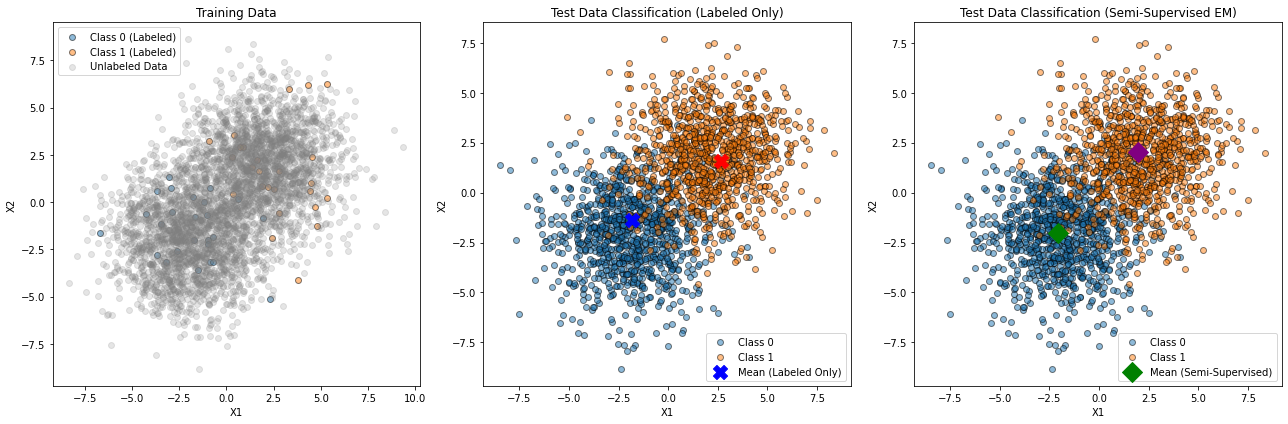

In [45]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(400)

def generate_data(n_labeled=50, n_unlabeled=4000, n_test=2000):
    """
    Generate data from a 2-component Gaussian mixture model.
    
    Parameters:
        n_labeled (int): Number of labeled training data points.
        n_unlabeled (int): Number of unlabeled training data points.
        n_test (int): Number of test data points.
        
    Returns:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): Labels for test data.
    """
    # Define parameters for two Gaussian components
    mean1 = np.array([-2, -2])
    mean2 = np.array([2, 2])
    cov = np.array([[4, 0], [0, 4]])  # Identity covariance

    # Generate labeled training data: 500 from each component
    X_labeled_1 = np.random.multivariate_normal(mean1, cov, n_labeled // 2)
    X_labeled_2 = np.random.multivariate_normal(mean2, cov, n_labeled // 2)
    X_labeled = np.vstack((X_labeled_1, X_labeled_2))
    y_labeled = np.hstack((np.zeros(n_labeled // 2), np.ones(n_labeled // 2)))

    # Generate unlabeled training data: mixed from both components
    n_unlabeled_1 = n_unlabeled // 2
    n_unlabeled_2 = n_unlabeled - n_unlabeled_1
    X_unlabeled_1 = np.random.multivariate_normal(mean1, cov, n_unlabeled_1)
    X_unlabeled_2 = np.random.multivariate_normal(mean2, cov, n_unlabeled_2)
    X_unlabeled = np.vstack((X_unlabeled_1, X_unlabeled_2))
    np.random.shuffle(X_unlabeled)  # Shuffle to mix components

    # Generate test data: 1000 from each component
    X_test_1 = np.random.multivariate_normal(mean1, cov, n_test // 2)
    X_test_2 = np.random.multivariate_normal(mean2, cov, n_test // 2)
    X_test = np.vstack((X_test_1, X_test_2))
    y_test = np.hstack((np.zeros(n_test // 2), np.ones(n_test // 2)))

    return X_labeled, y_labeled, X_unlabeled, X_test, y_test

def initialize_parameters(X, y, n_components=2):
    """
    Initialize the parameters for the EM algorithm.
    
    Parameters:
        X (np.ndarray): Combined data (labeled + unlabeled).
        y (np.ndarray): Labels for all data points (-1 for unlabeled).
        n_components (int): Number of Gaussian components.
        
    Returns:
        means (list): Initial means for the components.
        covariances (list): Initial covariance matrices.
        weights (list): Initial mixing coefficients.
    """
    means = []
    covariances = []
    weights = []
    
    for k in range(n_components):
        # Only consider labeled data for initializing means
        labeled_mask = (y == k)
        if np.any(labeled_mask):
            mean_k = X[labeled_mask].mean(axis=0)
        else:
            # If no labeled data for this component, initialize randomly
            mean_k = X[np.random.choice(X.shape[0])]
        means.append(mean_k)
        
        # Initialize covariance as identity
        cov_k = np.eye(X.shape[1])
        covariances.append(cov_k)
        
        # Initialize weights based on labeled data
        weight_k = np.mean(y == k)
        weights.append(weight_k)
    
    return means, covariances, weights

def semi_supervised_em(X_labeled, y_labeled, X_unlabeled, 
                      n_components=2, max_iters=100, tol=1e-4):
    """
    Perform semi-supervised EM algorithm.
    
    Parameters:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.
        n_components (int): Number of Gaussian components.
        max_iters (int): Maximum number of iterations.
        tol (float): Convergence threshold.
        
    Returns:
        means (list): Estimated means for the components.
        covariances (list): Estimated covariance matrices.
        weights (list): Estimated mixing coefficients.
    """
    # Combine labeled and unlabeled data
    X = np.vstack((X_labeled, X_unlabeled))
    n_labeled = X_labeled.shape[0]
    n_unlabeled = X_unlabeled.shape[0]
    
    # Create labels: 0 and 1 for labeled data, -1 for unlabeled data
    y = np.hstack((y_labeled, -1 * np.ones(n_unlabeled)))
    
    # Initialize parameters
    means, covariances, weights = initialize_parameters(X, y, n_components)
    
    for iteration in range(max_iters):
        prev_means = np.copy(means)
        
        # E-step: Compute responsibilities
        responsibilities = np.zeros((X.shape[0], n_components))
        for k in range(n_components):
            try:
                rv = multivariate_normal(mean=means[k], cov=covariances[k], allow_singular=True)
                responsibilities[:, k] = weights[k] * rv.pdf(X)
            except np.linalg.LinAlgError:
                print(f"Singular covariance matrix detected for component {k}. Adding regularization.")
                cov_k_reg = covariances[k] + 1e-6 * np.eye(X.shape[1])
                rv = multivariate_normal(mean=means[k], cov=cov_k_reg, allow_singular=True)
                responsibilities[:, k] = weights[k] * rv.pdf(X)
        sum_responsibilities = responsibilities.sum(axis=1, keepdims=True)
        # To avoid division by zero
        sum_responsibilities[sum_responsibilities == 0] = 1e-10
        responsibilities /= sum_responsibilities
        
        # For labeled data, set responsibilities to 1 for the correct class and 0 otherwise
        labeled_indices = np.where(y != -1)[0]
        responsibilities[labeled_indices, :] = 0
        responsibilities[labeled_indices, y_labeled.astype(int)] = 1
        
        # M-step: Update parameters
        Nk = responsibilities.sum(axis=0)
        
        # Avoid division by zero in case Nk[k] is zero
        Nk[Nk == 0] = 1e-10
        
        # Update weights
        weights = Nk / X.shape[0]
        
        # Update means
        for k in range(n_components):
            means[k] = X.T @ responsibilities[:, k] / Nk[k]
        
        # Update covariances
        for k in range(n_components):
            diff = X - means[k]
            cov_k = (responsibilities[:, k].reshape(-1,1) * diff).T @ diff / Nk[k]
            # To avoid singular covariance matrices
            cov_k += 1e-6 * np.eye(X.shape[1])
            covariances[k] = cov_k
        
        # Check for convergence
        mean_shift = np.linalg.norm(np.array(means) - np.array(prev_means))
        if mean_shift < tol:
            print(f'Converged at iteration {iteration + 1}')
            break
    else:
        print('Reached maximum iterations without convergence.')
    
    return means, covariances, weights

def estimate_means_labeled_only(X_labeled, y_labeled):
    """
    Estimate means using only labeled data.
    
    Parameters:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        
    Returns:
        means (list): Estimated means for the two components.
    """
    mean1 = X_labeled[y_labeled == 0].mean(axis=0)
    mean2 = X_labeled[y_labeled == 1].mean(axis=0)
    return [mean1, mean2]

def compute_accuracy(true_means, estimated_means, X_test, y_test):
    """
    Perform classification on test data and compute accuracy.
    
    Parameters:
        true_means (list): List of true means.
        estimated_means (list): List of estimated means.
        X_test (np.ndarray): Test data points.
        y_test (np.ndarray): True labels for test data.
        
    Returns:
        accuracy (float): Classification accuracy.
    """
    # Assign each test point to the nearest estimated mean
    distances = np.array([np.linalg.norm(X_test - mean, axis=1) for mean in estimated_means])
    y_pred = distances.argmin(axis=0)
    
    # Since the estimated means might not align with true labels, find the best mapping
    # Compute correlation between estimated labels and true labels
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    
    # Compute two possible mappings
    mapping1 = y_pred
    mapping2 = 1 - y_pred
    
    acc1 = accuracy_score(y_test_encoded, mapping1)
    acc2 = accuracy_score(y_test_encoded, mapping2)
    
    if acc1 > acc2:
        final_accuracy = acc1
        final_pred = mapping1
    else:
        final_accuracy = acc2
        final_pred = mapping2
    
    return final_accuracy

def main():
    # Step 1: Generate data
    X_labeled, y_labeled, X_unlabeled, X_test, y_test = generate_data()
    
    # Define true means for reference (not used in computation)
    true_mean1 = np.array([-2, -2])
    true_mean2 = np.array([2, 2])
    true_means = [true_mean1, true_mean2]
    
    # Step 2: Estimate means using only labeled data
    estimated_means_labeled = estimate_means_labeled_only(X_labeled, y_labeled)
    print("Estimated Means using only labeled data:")
    for idx, mean in enumerate(estimated_means_labeled):
        print(f"Component {idx}: {mean}")
    
    # Step 3: Run semi-supervised EM
    estimated_means_semi, _, _ = semi_supervised_em(X_labeled, y_labeled, X_unlabeled)
    print("\nEstimated Means using semi-supervised EM:")
    for idx, mean in enumerate(estimated_means_semi):
        print(f"Component {idx}: {mean}")
    
    # Step 4: Classification on test data
    accuracy_labeled = compute_accuracy(true_means, estimated_means_labeled, X_test, y_test)
    accuracy_semi = compute_accuracy(true_means, estimated_means_semi, X_test, y_test)
    
    print("\nClassification Accuracies on Test Data:")
    print(f"Using Only Labeled Data: {accuracy_labeled * 100:.2f}%")
    print(f"Using Semi-Supervised EM: {accuracy_semi * 100:.2f}%")
    
    # Step 5: Visualization (Optional)
    visualize = True  # Set to False to disable visualization
    if visualize:
        plt.figure(figsize=(18, 6))
        
        # Plot training data
        plt.subplot(1, 3, 1)
        plt.scatter(X_labeled[y_labeled == 0][:, 0], X_labeled[y_labeled == 0][:, 1],
                    label='Class 0 (Labeled)', alpha=0.5, edgecolor='k')
        plt.scatter(X_labeled[y_labeled == 1][:, 0], X_labeled[y_labeled == 1][:, 1],
                    label='Class 1 (Labeled)', alpha=0.5, edgecolor='k')
        plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1],
                    label='Unlabeled Data', alpha=0.2, color='gray')
        plt.title('Training Data')
        plt.legend()
        plt.xlabel('X1')
        plt.ylabel('X2')
        
        # Plot estimated means from labeled data
        plt.subplot(1, 3, 2)
        plt.scatter(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], label='Class 0', alpha=0.5, edgecolor='k')
        plt.scatter(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], label='Class 1', alpha=0.5, edgecolor='k')
        plt.scatter(estimated_means_labeled[0][0], estimated_means_labeled[0][1],
                    marker='X', color='blue', s=200, label='Mean (Labeled Only)')
        plt.scatter(estimated_means_labeled[1][0], estimated_means_labeled[1][1],
                    marker='X', color='red', s=200)
        plt.title('Test Data Classification (Labeled Only)')
        plt.legend()
        plt.xlabel('X1')
        plt.ylabel('X2')
        
        # Plot estimated means from semi-supervised EM
        plt.subplot(1, 3, 3)
        plt.scatter(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], label='Class 0', alpha=0.5, edgecolor='k')
        plt.scatter(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], label='Class 1', alpha=0.5, edgecolor='k')
        plt.scatter(estimated_means_semi[0][0], estimated_means_semi[0][1],
                    marker='D', color='green', s=200, label='Mean (Semi-Supervised)')
        plt.scatter(estimated_means_semi[1][0], estimated_means_semi[1][1],
                    marker='D', color='purple', s=200)
        plt.title('Test Data Classification (Semi-Supervised EM)')
        plt.legend()
        plt.xlabel('X1')
        plt.ylabel('X2')
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()

In [ ]:
###################################
###
###  Cluster-then-label logistic regression, performance evaluated on classification accuracy on test data
###
##################################

Data Generation Completed.
Labeled Data: 1000 samples
Unlabeled Data: 4000 samples
Test Data: 2000 samples

Logistic Regression Trained on Labeled Data Only.
Classification Accuracy (Labeled Only): 97.65%

Logistic Regression Trained on Labeled + Pseudo-Labeled Data.
Classification Accuracy (With Unlabeled Data): 97.70%

Comparison of Classification Accuracies on Test Data:
1. Using Only Labeled Data: 97.65%
2. Using Labeled + Unlabeled Data: 97.70%


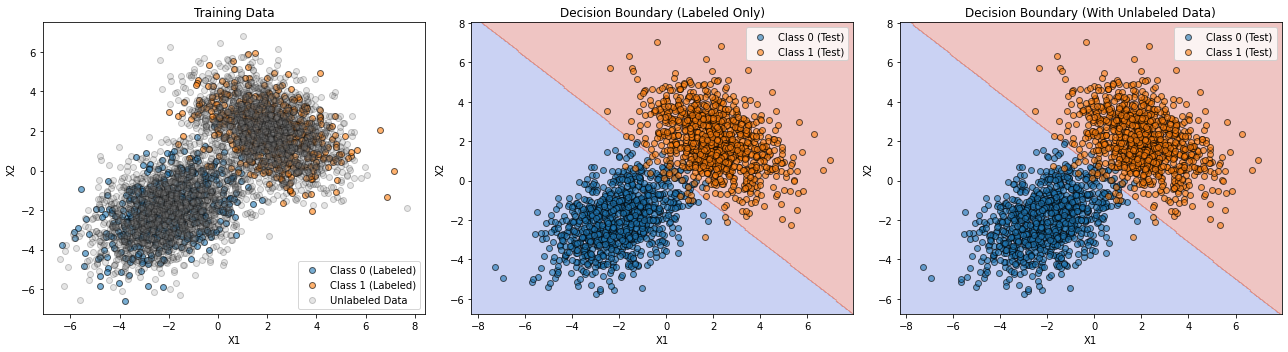

In [56]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(1997)

def generate_data(n_labeled=1000, n_unlabeled=4000, n_test=2000):
    """
    Generate data from a 2-component Gaussian mixture model with unequal covariances.

    Parameters:
        n_labeled (int): Number of labeled training data points.
        n_unlabeled (int): Number of unlabeled training data points.
        n_test (int): Number of test data points.

    Returns:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): Labels for test data.
    """
    # Define parameters for two Gaussian components with unequal covariance matrices
    mean1 = np.array([-2, -2])
    mean2 = np.array([2, 2])
    cov1 = np.array([[2, 0.8], [0.8, 2]])    # Covariance for class 0
    cov2 = np.array([[2, -0.8], [-0.8, 2]])  # Covariance for class 1

    # Generate labeled training data: 500 from each component
    X_labeled_1 = np.random.multivariate_normal(mean1, cov1, n_labeled // 2)
    X_labeled_2 = np.random.multivariate_normal(mean2, cov2, n_labeled // 2)
    X_labeled = np.vstack((X_labeled_1, X_labeled_2))
    y_labeled = np.hstack((np.zeros(n_labeled // 2), np.ones(n_labeled // 2)))

    # Generate unlabeled training data: mixed from both components
    n_unlabeled_1 = n_unlabeled // 2
    n_unlabeled_2 = n_unlabeled - n_unlabeled_1
    X_unlabeled_1 = np.random.multivariate_normal(mean1, cov1, n_unlabeled_1)
    X_unlabeled_2 = np.random.multivariate_normal(mean2, cov2, n_unlabeled_2)
    X_unlabeled = np.vstack((X_unlabeled_1, X_unlabeled_2))
    np.random.shuffle(X_unlabeled)  # Shuffle to mix components

    # Generate test data: 1000 from each component
    X_test_1 = np.random.multivariate_normal(mean1, cov1, n_test // 2)
    X_test_2 = np.random.multivariate_normal(mean2, cov2, n_test // 2)
    X_test = np.vstack((X_test_1, X_test_2))
    y_test = np.hstack((np.zeros(n_test // 2), np.ones(n_test // 2)))

    return X_labeled, y_labeled, X_unlabeled, X_test, y_test

def train_logistic_regression(X_train, y_train):
    """
    Train a logistic regression model.

    Parameters:
        X_train (np.ndarray): Training data.
        y_train (np.ndarray): Training labels.

    Returns:
        model (LogisticRegression): Trained logistic regression model.
    """
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    return model

def cluster_then_label_logistic_regression(X_labeled, y_labeled, X_unlabeled):
    """
    Perform cluster-then-label approach: cluster the combined data,
    assign pseudo-labels to unlabeled data based on cluster assignments,
    and train logistic regression on combined labeled and pseudo-labeled data.

    Parameters:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.

    Returns:
        model (LogisticRegression): Trained logistic regression model using pseudo-labeled data.
        y_combined (np.ndarray): Combined labels (original and pseudo).
    """
    # Combine labeled and unlabeled data
    X_combined = np.vstack((X_labeled, X_unlabeled))
    n_labeled = X_labeled.shape[0]
    n_unlabeled = X_unlabeled.shape[0]

    # Fit Gaussian Mixture Model with 2 components
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(X_combined)
    cluster_assignments = gmm.predict(X_combined)

    # Map clusters to labels based on labeled data
    cluster_labels = {}
    for cluster in np.unique(cluster_assignments):
        # Find indices of labeled data in this cluster
        indices = np.where(cluster_assignments[:n_labeled] == cluster)[0]
        if len(indices) == 0:
            # If no labeled data in this cluster, assign randomly
            assigned_label = np.random.randint(0, 2)
        else:
            # Majority vote among labeled data in this cluster
            assigned_label = np.bincount(y_labeled[indices].astype(int)).argmax()
        cluster_labels[cluster] = assigned_label

    # Assign pseudo-labels to unlabeled data
    pseudo_labels = np.array([cluster_labels[cluster] for cluster in cluster_assignments[n_labeled:]])

    # Combine original labels with pseudo-labels
    y_combined = np.hstack((y_labeled, pseudo_labels))

    # Train logistic regression on combined data
    model = train_logistic_regression(X_combined, y_combined)

    return model, y_combined

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the logistic regression model on test data.

    Parameters:
        model (LogisticRegression): Trained logistic regression model.
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): True labels for test data.

    Returns:
        accuracy (float): Classification accuracy on test data.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def visualize_data(X_labeled, y_labeled, X_unlabeled, X_test, y_test, 
                  model_labeled, model_pseudo, cluster_labels_assignment=None):
    """
    Visualize the labeled data, unlabeled data, and decision boundaries.

    Parameters:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): Test labels.
        model_labeled (LogisticRegression): Model trained on labeled data only.
        model_pseudo (LogisticRegression): Model trained on labeled + pseudo-labeled data.
        cluster_labels_assignment (np.ndarray): Cluster assignments for combined data (optional).
    """
    plt.figure(figsize=(18, 5))

    # Plot training data
    plt.subplot(1, 3, 1)
    plt.scatter(X_labeled[y_labeled == 0][:, 0], X_labeled[y_labeled == 0][:, 1],
                label='Class 0 (Labeled)', alpha=0.6, edgecolor='k')
    plt.scatter(X_labeled[y_labeled == 1][:, 0], X_labeled[y_labeled == 1][:, 1],
                label='Class 1 (Labeled)', alpha=0.6, edgecolor='k')
    plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], 
                label='Unlabeled Data', alpha=0.2, color='gray', edgecolor='k')
    plt.title('Training Data')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    # Define a mesh grid for plotting decision boundaries
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Plot decision boundary for model trained on labeled data
    Z_labeled = model_labeled.predict(grid).reshape(xx.shape)
    plt.subplot(1, 3, 2)
    plt.contourf(xx, yy, Z_labeled, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], 
                label='Class 0 (Test)', alpha=0.6, edgecolor='k')
    plt.scatter(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], 
                label='Class 1 (Test)', alpha=0.6, edgecolor='k')
    plt.title('Decision Boundary (Labeled Only)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    # Plot decision boundary for model trained on labeled + pseudo-labeled data
    Z_pseudo = model_pseudo.predict(grid).reshape(xx.shape)
    plt.subplot(1, 3, 3)
    plt.contourf(xx, yy, Z_pseudo, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], 
                label='Class 0 (Test)', alpha=0.6, edgecolor='k')
    plt.scatter(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], 
                label='Class 1 (Test)', alpha=0.6, edgecolor='k')
    plt.title('Decision Boundary (With Unlabeled Data)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Step 1: Generate Data
    X_labeled, y_labeled, X_unlabeled, X_test, y_test = generate_data()
    print("Data Generation Completed.")
    print(f"Labeled Data: {X_labeled.shape[0]} samples")
    print(f"Unlabeled Data: {X_unlabeled.shape[0]} samples")
    print(f"Test Data: {X_test.shape[0]} samples\n")

    # Step 2: Train Logistic Regression on Labeled Data Only
    model_labeled = train_logistic_regression(X_labeled, y_labeled)
    accuracy_labeled = evaluate_model(model_labeled, X_test, y_test)
    print("Logistic Regression Trained on Labeled Data Only.")
    print(f"Classification Accuracy (Labeled Only): {accuracy_labeled * 100:.2f}%\n")

    # Step 3: Cluster-Then-Label and Train Logistic Regression
    model_pseudo, y_combined = cluster_then_label_logistic_regression(X_labeled, y_labeled, X_unlabeled)
    accuracy_pseudo = evaluate_model(model_pseudo, X_test, y_test)
    print("Logistic Regression Trained on Labeled + Pseudo-Labeled Data.")
    print(f"Classification Accuracy (With Unlabeled Data): {accuracy_pseudo * 100:.2f}%\n")

    # Step 4: Compare Accuracies
    print("Comparison of Classification Accuracies on Test Data:")
    print(f"1. Using Only Labeled Data: {accuracy_labeled * 100:.2f}%")
    print(f"2. Using Labeled + Unlabeled Data: {accuracy_pseudo * 100:.2f}%")

    # Step 5: Visualization (Optional)
    visualize = True  # Set to False to disable visualization
    if visualize:
        visualize_data(X_labeled, y_labeled, X_unlabeled, X_test, y_test, 
                      model_labeled, model_pseudo)

if __name__ == "__main__":
    main()

In [ ]:
###################################
###
###  graph-based semi-supervised learning (Label propagation using rbf kernel), performance evaluated on classification accuracy on test data
###
##################################

Data Generation Completed.
Labeled Data: 1000 samples
Unlabeled Data: 4000 samples
Test Data: 2000 samples

Supervised Logistic Regression Trained on Labeled Data Only.
Classification Accuracy (Supervised): 99.65%

Semi-Supervised LabelSpreading Model Trained on Labeled + Unlabeled Data.
Classification Accuracy (Semi-Supervised): 99.80%

Comparison of Classification Accuracies on Test Data:
1. Supervised Learning (Labeled Only): 99.65%
2. Graph-Based Semi-Supervised Learning: 99.80%



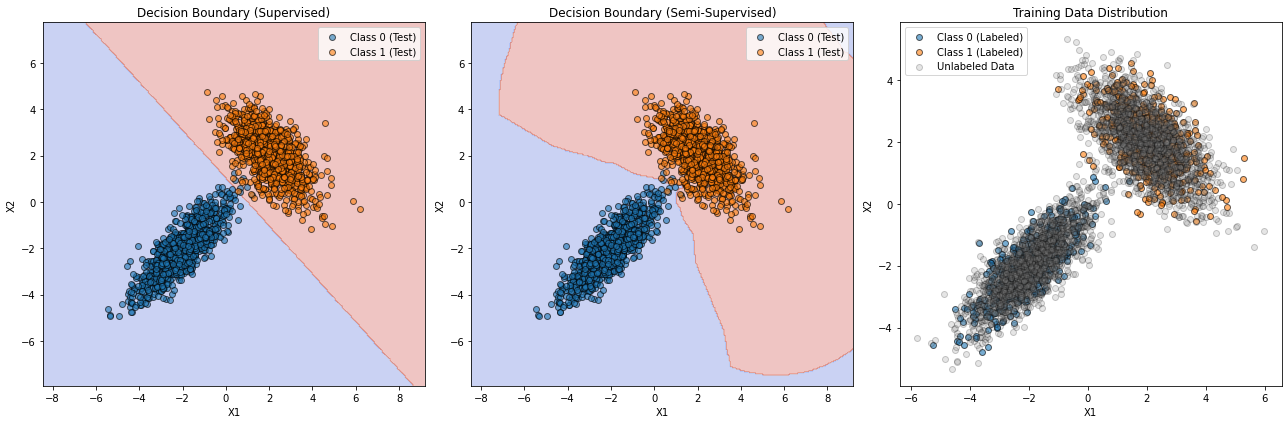

In [57]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(42)

def generate_data(n_labeled=1000, n_unlabeled=4000, n_test=2000):
    """
    Generate data from a 2-component Gaussian mixture model with unequal covariance matrices.

    Parameters:
        n_labeled (int): Number of labeled training data points.
        n_unlabeled (int): Number of unlabeled training data points.
        n_test (int): Number of test data points.

    Returns:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): Labels for test data.
    """
    # Define parameters for two Gaussian components with unequal covariance matrices
    mean1 = np.array([-2, -2])
    mean2 = np.array([2, 2])
    cov1 = np.array([[1, 0.8], [0.8, 1]])    # Covariance for class 0
    cov2 = np.array([[1, -0.6], [-0.6, 1]])  # Covariance for class 1

    # Generate labeled training data: n_labeled/2 from each component
    X_labeled_1 = np.random.multivariate_normal(mean1, cov1, n_labeled // 2)
    X_labeled_2 = np.random.multivariate_normal(mean2, cov2, n_labeled // 2)
    X_labeled = np.vstack((X_labeled_1, X_labeled_2))
    y_labeled = np.hstack((np.zeros(n_labeled // 2), np.ones(n_labeled // 2)))

    # Generate unlabeled training data: n_unlabeled/2 from each component
    n_unlabeled_1 = n_unlabeled // 2
    n_unlabeled_2 = n_unlabeled - n_unlabeled_1
    X_unlabeled_1 = np.random.multivariate_normal(mean1, cov1, n_unlabeled_1)
    X_unlabeled_2 = np.random.multivariate_normal(mean2, cov2, n_unlabeled_2)
    X_unlabeled = np.vstack((X_unlabeled_1, X_unlabeled_2))
    np.random.shuffle(X_unlabeled)  # Shuffle to mix components

    # Generate test data: n_test/2 from each component
    X_test_1 = np.random.multivariate_normal(mean1, cov1, n_test // 2)
    X_test_2 = np.random.multivariate_normal(mean2, cov2, n_test // 2)
    X_test = np.vstack((X_test_1, X_test_2))
    y_test = np.hstack((np.zeros(n_test // 2), np.ones(n_test // 2)))

    return X_labeled, y_labeled, X_unlabeled, X_test, y_test

def train_supervised_model(X_train, y_train):
    """
    Train a supervised Logistic Regression model.

    Parameters:
        X_train (np.ndarray): Training data.
        y_train (np.ndarray): Training labels.

    Returns:
        model (LogisticRegression): Trained Logistic Regression model.
    """
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    return model

def train_semi_supervised_model(X_labeled, y_labeled, X_unlabeled, kernel='rbf', gamma=20):
    """
    Train a semi-supervised LabelSpreading model.

    Parameters:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.
        kernel (str): Kernel type for affinity ('rbf' or 'knn').
        gamma (float): Kernel coefficient for 'rbf'.

    Returns:
        model (LabelSpreading): Trained LabelSpreading model.
    """
    # Combine labeled and unlabeled data
    X_combined = np.vstack((X_labeled, X_unlabeled))
    n_labeled = X_labeled.shape[0]
    n_unlabeled = X_unlabeled.shape[0]

    # Prepare labels: labeled data as is, unlabeled data as -1
    y_combined = np.hstack((y_labeled, -1 * np.ones(n_unlabeled)))

    # Initialize LabelSpreading model
    model = LabelSpreading(kernel=kernel, gamma=gamma, max_iter=1000)
    model.fit(X_combined, y_combined)

    return model

def evaluate_model(model, X_test, y_test, semi_supervised=False):
    """
    Evaluate the model on test data.

    Parameters:
        model: Trained model (LogisticRegression or LabelSpreading).
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): True labels for test data.
        semi_supervised (bool): If True, model is semi-supervised.

    Returns:
        accuracy (float): Classification accuracy.
    """
    if semi_supervised:
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def visualize_results(X_labeled, y_labeled, X_unlabeled, X_test, y_test, 
                     model_supervised, model_semi_supervised):
    """
    Visualize the data distributions and decision boundaries.

    Parameters:
        X_labeled (np.ndarray): Labeled training data.
        y_labeled (np.ndarray): Labels for labeled training data.
        X_unlabeled (np.ndarray): Unlabeled training data.
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): Test labels.
        model_supervised (LogisticRegression): Supervised model.
        model_semi_supervised (LabelSpreading): Semi-supervised model.
    """
    plt.figure(figsize=(18, 6))

    # Define a mesh grid for plotting decision boundaries
    x_min, x_max = X_test[:, 0].min() - 3, X_test[:, 0].max() + 3
    y_min, y_max = X_test[:, 1].min() - 3, X_test[:, 1].max() + 3
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Plot Supervised Decision Boundary
    plt.subplot(1, 3, 1)
    Z_supervised = model_supervised.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, Z_supervised, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], 
                label='Class 0 (Test)', alpha=0.6, edgecolor='k')
    plt.scatter(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], 
                label='Class 1 (Test)', alpha=0.6, edgecolor='k')
    plt.title('Decision Boundary (Supervised)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    # Plot Semi-Supervised Decision Boundary
    plt.subplot(1, 3, 2)
    Z_semi = model_semi_supervised.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, Z_semi, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], 
                label='Class 0 (Test)', alpha=0.6, edgecolor='k')
    plt.scatter(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], 
                label='Class 1 (Test)', alpha=0.6, edgecolor='k')
    plt.title('Decision Boundary (Semi-Supervised)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    # Plot Data Distribution
    plt.subplot(1, 3, 3)
    plt.scatter(X_labeled[y_labeled == 0][:,0], X_labeled[y_labeled == 0][:,1], 
                label='Class 0 (Labeled)', alpha=0.6, edgecolor='k')
    plt.scatter(X_labeled[y_labeled == 1][:,0], X_labeled[y_labeled == 1][:,1], 
                label='Class 1 (Labeled)', alpha=0.6, edgecolor='k')
    plt.scatter(X_unlabeled[:,0], X_unlabeled[:,1], 
                label='Unlabeled Data', alpha=0.2, color='gray', edgecolor='k')
    plt.title('Training Data Distribution')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Step 1: Generate Data
    X_labeled, y_labeled, X_unlabeled, X_test, y_test = generate_data()
    print("Data Generation Completed.")
    print(f"Labeled Data: {X_labeled.shape[0]} samples")
    print(f"Unlabeled Data: {X_unlabeled.shape[0]} samples")
    print(f"Test Data: {X_test.shape[0]} samples\n")

    # Step 2: Train Supervised Model (Only Labeled Data)
    model_supervised = train_supervised_model(X_labeled, y_labeled)
    accuracy_supervised = evaluate_model(model_supervised, X_test, y_test, semi_supervised=False)
    print("Supervised Logistic Regression Trained on Labeled Data Only.")
    print(f"Classification Accuracy (Supervised): {accuracy_supervised * 100:.2f}%\n")

    # Step 3: Train Semi-Supervised Model (Using Unlabeled Data)
    model_semi_supervised = train_semi_supervised_model(X_labeled, y_labeled, X_unlabeled)
    accuracy_semi_supervised = evaluate_model(model_semi_supervised, X_test, y_test, semi_supervised=True)
    print("Semi-Supervised LabelSpreading Model Trained on Labeled + Unlabeled Data.")
    print(f"Classification Accuracy (Semi-Supervised): {accuracy_semi_supervised * 100:.2f}%\n")

    # Step 4: Compare Accuracies
    print("Comparison of Classification Accuracies on Test Data:")
    print(f"1. Supervised Learning (Labeled Only): {accuracy_supervised * 100:.2f}%")
    print(f"2. Graph-Based Semi-Supervised Learning: {accuracy_semi_supervised * 100:.2f}%\n")

    # Step 5: Visualization (Optional)
    visualize = True  # Set to False to disable visualization
    if visualize:
        visualize_results(X_labeled, y_labeled, X_unlabeled, X_test, y_test, 
                         model_supervised, model_semi_supervised)

if __name__ == "__main__":
    main()

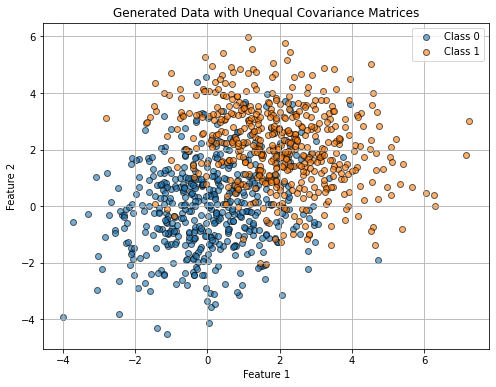

Total Training Samples: 800
Labeled Samples: 32
Unlabeled Samples: 768



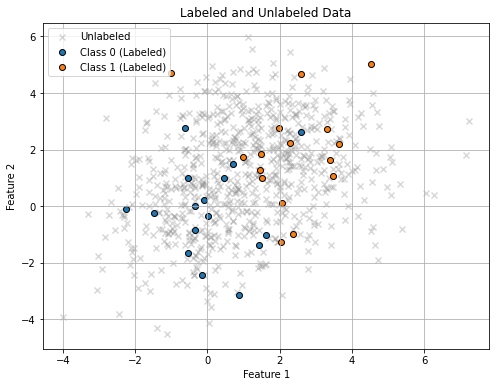

Supervised SVM Test Accuracy: 0.8350
Iteration 0: Adding 764 pseudo-labeled samples.
Iteration 1: Adding 4 pseudo-labeled samples.
Iteration 1: No more unlabeled data. Stopping.
Semi-Supervised SVM (Self-Training) Test Accuracy: 0.8500

--- Summary ---
Supervised SVM Accuracy: 0.8350
Semi-Supervised SVM Accuracy: 0.8500


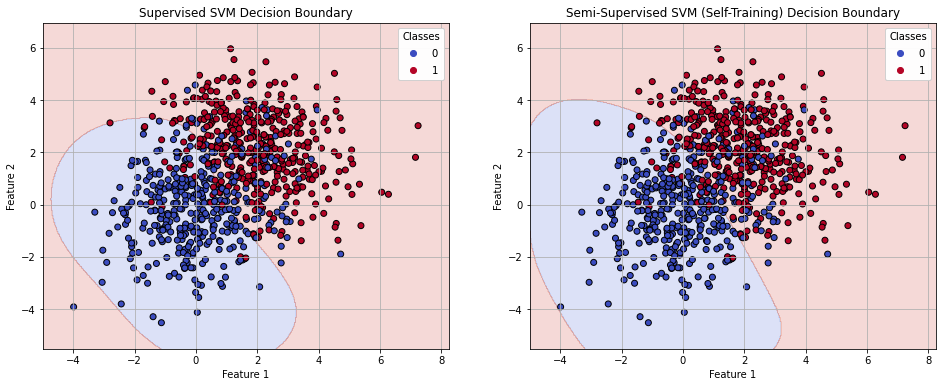

In [92]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

def generate_unequal_covariance_data(n_samples=1000, n_features=2, 
                                    class_sep=2.0, random_state=42):
    """
    Generates a binary classification dataset with unequal covariance matrices.
    
    Parameters:
    - n_samples: Total number of samples.
    - n_features: Number of features (dimensions).
    - class_sep: Separation between the two classes.
    - random_state: Seed for reproducibility.
    
    Returns:
    - X: Feature matrix.
    - y: Labels vector.
    """
    np.random.seed(random_state)
    n_samples_per_class = n_samples // 2
    
    # Define different means for each class
    mean1 = np.zeros(n_features)
    mean2 = np.ones(n_features) * class_sep
    
    # Define different covariance matrices for each class
    cov1 = np.array([[2.0, 0.5],
                     [0.5, 2.5]])
    cov2 = np.array([[2.5, -0.7],
                     [-0.7, 2.0]])
    
    # Generate samples for each class
    X_class1 = np.random.multivariate_normal(mean1, cov1, n_samples_per_class)
    X_class2 = np.random.multivariate_normal(mean2, cov2, n_samples_per_class)
    
    # Combine the data
    X = np.vstack((X_class1, X_class2))
    y = np.hstack((np.zeros(n_samples_per_class), np.ones(n_samples_per_class)))
    
    return X, y

def create_labeled_unlabeled(X, y, labeled_ratio=0.1, random_state=42):
    """
    Splits the data into labeled and unlabeled sets.
    Unlabeled data have their labels set to -1.
    
    Parameters:
    - X: Feature matrix.
    - y: Labels vector.
    - labeled_ratio: Proportion of data to be labeled.
    - random_state: Seed for reproducibility.
    
    Returns:
    - X_labeled: Labeled feature matrix.
    - y_labeled: Labeled labels vector.
    - X_unlabeled: Unlabeled feature matrix.
    - y_unlabeled: Unlabeled labels vector (set to -1).
    """
    np.random.seed(random_state)
    n_total = len(y)
    n_labeled = int(n_total * labeled_ratio)
    
    # Stratified sampling to maintain class proportions
    X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
        X, y, train_size=n_labeled, stratify=y, random_state=random_state)
    
    y_unlabeled = -1 * np.ones(len(X_unlabeled))
    
    return X_labeled, y_labeled, X_unlabeled, y_unlabeled

def self_training_svm(X_labeled, y_labeled, X_unlabeled, 
                     base_classifier, threshold=1.0, max_iterations=10):
    """
    Implements a self-training algorithm to approximate S3VM.
    
    Parameters:
    - X_labeled: Initially labeled data features.
    - y_labeled: Initially labeled data labels.
    - X_unlabeled: Unlabeled data features.
    - base_classifier: An instance of sklearn classifier with fit and predict methods.
    - threshold: Minimum decision_function absolute value to consider prediction confident.
    - max_iterations: Maximum number of self-training iterations.
    
    Returns:
    - classifier: Trained classifier after self-training.
    """
    X_current = X_labeled.copy()
    y_current = y_labeled.copy()
    X_unlabeled_current = X_unlabeled.copy()
    
    for iteration in range(max_iterations):
        # Train the classifier
        classifier = base_classifier.fit(X_current, y_current)
        
        # Predict decision function on unlabeled data
        decision_scores = classifier.decision_function(X_unlabeled_current)
        
        # For binary classification, higher absolute decision scores indicate higher confidence
        confidence = np.abs(decision_scores)
        predictions = classifier.predict(X_unlabeled_current)
        
        # Select high-confidence predictions
        high_confidence_mask = confidence >= threshold
        high_confidence_indices = np.where(high_confidence_mask)[0]
        
        if len(high_confidence_indices) == 0:
            print(f"Iteration {iteration}: No high-confidence predictions. Stopping.")
            break
        
        # Add high-confidence predictions to the labeled set
        X_new = X_unlabeled_current[high_confidence_indices]
        y_new = predictions[high_confidence_indices]
        
        print(f"Iteration {iteration}: Adding {len(y_new)} pseudo-labeled samples.")
        
        X_current = np.vstack((X_current, X_new))
        y_current = np.concatenate((y_current, y_new))
        
        # Remove the newly labeled data from the unlabeled set
        X_unlabeled_current = np.delete(X_unlabeled_current, high_confidence_indices, axis=0)
        
        # If no more unlabeled data, stop
        if len(X_unlabeled_current) == 0:
            print(f"Iteration {iteration}: No more unlabeled data. Stopping.")
            break
    
    return classifier

def plot_decision_boundaries(clf_supervised, clf_semi, X_train, y_train, X_test, y_test):
    """
    Plots the decision boundaries of supervised and semi-supervised classifiers.
    
    Parameters:
    - clf_supervised: Trained supervised classifier.
    - clf_semi: Trained semi-supervised classifier.
    - X_train: Training features.
    - y_train: Training labels.
    - X_test: Test features.
    - y_test: Test labels.
    """
    def plot_clf(clf, X, y, ax, title):
        # Define bounds of the plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                             np.linspace(y_min, y_max, 500))
        
        # Predict over the grid
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot contour
        ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
        scatter = ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
        ax.set_title(title)
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)
        ax.grid(True)
    
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    plot_clf(clf_supervised, X_train, y_train, axs[0], 'Supervised SVM Decision Boundary')
    plot_clf(clf_semi, X_train, y_train, axs[1], 'Semi-Supervised SVM (Self-Training) Decision Boundary')
    plt.show()

def main():
    # 1. Generate Data with Unequal Covariance Matrices
    X, y = generate_unequal_covariance_data(n_samples=1000, n_features=2, 
                                           class_sep=2.0, random_state=42)
    
    # Optional: Visualize the generated data
    plt.figure(figsize=(8,6))
    plt.scatter(X[y==0][:,0], X[y==0][:,1], label='Class 0', alpha=0.6, edgecolors='k')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], label='Class 1', alpha=0.6, edgecolors='k')
    plt.title('Generated Data with Unequal Covariance Matrices')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. Split into Train and Test Sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Create Labeled and Unlabeled Sets from Training Data
    labeled_ratio = 0.04  # 10% labeled data
    X_labeled, y_labeled, X_unlabeled, y_unlabeled = create_labeled_unlabeled(
        X_train_full, y_train_full, labeled_ratio=labeled_ratio, random_state=42)
    
    print(f"Total Training Samples: {len(X_train_full)}")
    print(f"Labeled Samples: {len(X_labeled)}")
    print(f"Unlabeled Samples: {len(X_unlabeled)}\n")
    
    # Optional: Visualize labeled and unlabeled data
    plt.figure(figsize=(8,6))
    plt.scatter(X_unlabeled[:,0], X_unlabeled[:,1], label='Unlabeled', alpha=0.3, marker='x', color='gray')
    plt.scatter(X_labeled[y_labeled==0][:,0], X_labeled[y_labeled==0][:,1], label='Class 0 (Labeled)', edgecolors='k')
    plt.scatter(X_labeled[y_labeled==1][:,0], X_labeled[y_labeled==1][:,1], label='Class 1 (Labeled)', edgecolors='k')
    plt.title('Labeled and Unlabeled Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Define Base Classifiers
    # Using linear kernel; you can experiment with 'rbf' or others
    base_clf_supervised = SVC(kernel='rbf', probability=False, gamma='scale', random_state=42)
    base_clf_semi = SVC(kernel='rbf', probability=False, gamma='scale', random_state=42)
    
    # 5. Supervised Training
    clf_supervised = base_clf_supervised.fit(X_labeled, y_labeled)
    y_pred_supervised = clf_supervised.predict(X_test)
    acc_supervised = accuracy_score(y_test, y_pred_supervised)
    print(f"Supervised SVM Test Accuracy: {acc_supervised:.4f}")
    
    # 6. Semi-Supervised Training (Approximated S3VM via Self-Training)
    # Adjust threshold based on decision_function distribution
    # You might need to tune this value based on your dataset
    threshold = 0.01  # Example threshold; adjust as needed
    
    clf_semi = self_training_svm(
        X_labeled, y_labeled, X_unlabeled, 
        base_classifier=base_clf_semi, 
        threshold=threshold, 
        max_iterations=10
    )
    y_pred_semi = clf_semi.predict(X_test)
    acc_semi = accuracy_score(y_test, y_pred_semi)
    print(f"Semi-Supervised SVM (Self-Training) Test Accuracy: {acc_semi:.4f}")
    
    # 7. Summary
    print("\n--- Summary ---")
    print(f"Supervised SVM Accuracy: {acc_supervised:.4f}")
    print(f"Semi-Supervised SVM Accuracy: {acc_semi:.4f}")
    
    # 8. Visualization of Decision Boundaries
    plot_decision_boundaries(clf_supervised, clf_semi, X_train_full, y_train_full, X_test, y_test)

if __name__ == "__main__":
    main()

In [ ]:
#############################################################
####
#### contrastive learning on a small subset of the MNIST dataset using a 
#### Siamese Network architecture. The script includes data preparation, model definition, 
#### training, and visualization of the learned embeddings using t-SNE.
####
#############################################################

Using device: cpu
Epoch [1/50], Loss: 1.1856
Epoch [2/50], Loss: 1.1024
Epoch [3/50], Loss: 1.1151
Epoch [4/50], Loss: 1.1037
Epoch [5/50], Loss: 1.0912
Epoch [6/50], Loss: 1.0946
Epoch [7/50], Loss: 1.0769
Epoch [8/50], Loss: 1.0934
Epoch [9/50], Loss: 1.0652
Epoch [10/50], Loss: 1.1098
Epoch [11/50], Loss: 1.0545
Epoch [12/50], Loss: 1.1014
Epoch [13/50], Loss: 1.0851
Epoch [14/50], Loss: 1.0932
Epoch [15/50], Loss: 1.0856
Epoch [16/50], Loss: 1.0747
Epoch [17/50], Loss: 1.0933
Epoch [18/50], Loss: 1.0444
Epoch [19/50], Loss: 1.0745
Epoch [20/50], Loss: 1.0701
Epoch [21/50], Loss: 1.0870
Epoch [22/50], Loss: 1.0865
Epoch [23/50], Loss: 1.0890
Epoch [24/50], Loss: 1.0516
Epoch [25/50], Loss: 1.0770
Epoch [26/50], Loss: 1.0493
Epoch [27/50], Loss: 1.0698
Epoch [28/50], Loss: 1.0833
Epoch [29/50], Loss: 1.0513
Epoch [30/50], Loss: 1.0659
Epoch [31/50], Loss: 1.0636
Epoch [32/50], Loss: 1.0462
Epoch [33/50], Loss: 1.0435
Epoch [34/50], Loss: 1.0523
Epoch [35/50], Loss: 1.0536
Epoch [36/5

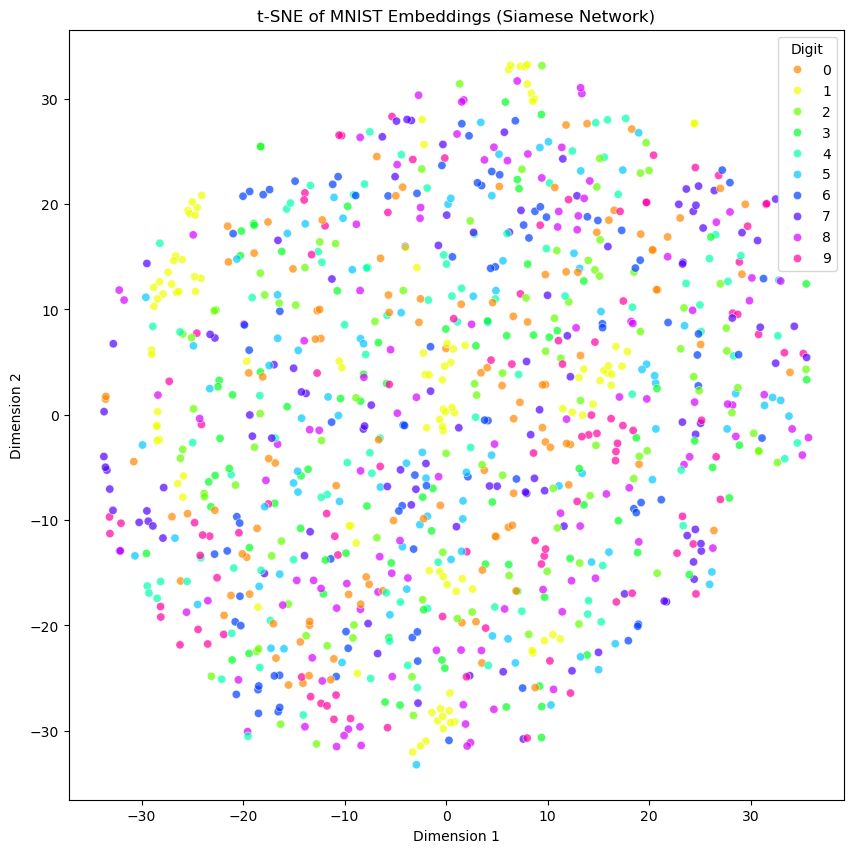

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Step 3: Define SiameseMNIST Dataset
class SiameseMNIST(Dataset):
    def __init__(self, mnist_subset):
        """
        Args:
            mnist_subset (torch.utils.data.Subset): A subset of the MNIST dataset.
        """
        self.mnist = mnist_subset
        self.transform = self.mnist.dataset.transform  # Access transform via the underlying dataset

        # Create a dictionary to hold the indices for each class
        self.class_to_indices = {}
        for idx in range(len(self.mnist)):
            _, label = self.mnist[idx]
            if label in self.class_to_indices:
                self.class_to_indices[label].append(idx)
            else:
                self.class_to_indices[label] = [idx]

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img1, label1 = self.mnist[idx]

        # Decide randomly to pair with same or different class
        should_same = np.random.randint(0, 2)
        if should_same:
            # Pair with the same class but different image
            idx2 = idx
            while idx2 == idx:
                idx2 = np.random.choice(self.class_to_indices[label1])
        else:
            # Pair with a different class
            label2 = np.random.choice(list(self.class_to_indices.keys()))
            while label2 == label1:
                label2 = np.random.choice(list(self.class_to_indices.keys()))
            idx2 = np.random.choice(self.class_to_indices[label2])

        img2, label2 = self.mnist[idx2]

        label = torch.tensor(int(label1 == label2), dtype=torch.float32)

        return img1, img2, label

# Step 5: Define the Siamese Network
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),  # Input channels=1 (grayscale), Output channels=32
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 12x12

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 8x8 -> 2x2
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),  # Adjusted based on the output size after conv layers
            nn.ReLU(),
            nn.Linear(256, 128)  # Embedding dimension
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        o1 = self.embedding_net(x1)
        o2 = self.embedding_net(x2)
        return o1, o2

# Step 6: Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss

def main():
    # Step 4: Load Data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Download MNIST training data
    mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Create a small subset
    subset_size = 1000
    subset_indices = np.random.choice(len(mnist_train), subset_size, replace=False)
    mnist_subset = torch.utils.data.Subset(mnist_train, subset_indices)

    # Create the Siamese dataset
    siamese_dataset = SiameseMNIST(mnist_subset)

    # Create DataLoader
    batch_size = 64
    train_loader = DataLoader(siamese_dataset, batch_size=batch_size, shuffle=True)

    # Step 7: Initialize Model
    embedding_net = EmbeddingNet()
    model = SiameseNetwork(embedding_net)
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Check if CUDA is available and use it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # Step 8: Train
    num_epochs = 50
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Step 9: Extract Embeddings
    model.eval()

    # For visualization, we use the same subset
    test_loader = DataLoader(mnist_subset, batch_size=batch_size, shuffle=False)

    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            emb = model.embedding_net(images)
            embeddings.append(emb.cpu().numpy())
            labels.append(label.cpu().numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    # Step 10: Visualize the Embeddings with t-SNE
    print("Performing t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 10))
    palette = sns.color_palette("hsv", 10)
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=labels,
        palette=palette,
        legend='full',
        alpha=0.7
    )
    plt.title("t-SNE of MNIST Embeddings (Siamese Network)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title='Digit')
    plt.show()

if __name__ == "__main__":
    main()